# **TCC_p03_Classificação_DCNN.ipynb**

# Etapa 1: Preparar os arquivos de treinamento

1.   Importação de bibliotecas

* Pandas: para criação e manipulação de dataframes
* re: para utilização das expressões regulares em operações de transformações em string.
* numpy: para trabalhar com array.
* string: para importar sinais de pontuação.
* random: para misturar os dados de treinamento.
* nltk: usada para tokenizar textos em sentenças dos votos e dos resumos para a impressão do pdf com os resumos.
* nltk punkt: Punkt é uma ferramenta de segmentação de frases neutra em termos de linguagem utilizada na tokenização.
* nltk: para obter pacote para stemização.
* seaborn: biblioteca para visualização de dados baseada em Matplotlib para exibir a matriz de confusão do sklearn como mapa de calor e as contagens de observações em cada categoria categórica usando barras.
* matplotlib: biblioteca para a criação de visualizações estáticas, animadas e interativas em Python. Utilizada para fazer alterações nas figuras: por exemplo, criar uma figura, criar uma área de plotagem em uma figura, plotar algumas linhas em uma área de plotagem e decorar a plotagem com rótulos.
* sklearn: para utilização das métricas de classificação matriz de confusão e acurácia.

2. Importação do TensorFlow
> O TensorFlow é uma plataforma completa de código aberto para machine learning. Ele tem um ecossistema abrangente e flexível de ferramentas, bibliotecas e recursos da comunidade que permite aos pesquisadores levar adiante ML de última geração e aos desenvolvedores criar e implantar aplicativos com tecnologia de ML. https://www.tensorflow.org/?hl=pt-br
* modelo: conforme documentação do TensorFlow, para fazer o aprendizado de máquina no TensorFlow, provavelmente você precisará definir, salvar e restaurar um modelo. Um modelo é, abstratamente: 
Uma função que calcula algo em tensores (uma passagem para frente). A maioria dos modelos é feita de camadas. Camadas são funções com uma estrutura matemática conhecida que podem ser reutilizadas e têm variáveis ​​treináveis. 
* layers: camadas são terminologia de aprendizado profundo para "objetos": eles têm estado interno e métodos que usam esse estado.
* Tokenizer: a classe TensorFlow (Keras) Tokenizer é usada para automatizar a tokenização de nossos dados de treinamento e converter os textos em sequências númericas.
* pad_sequences: usada para preencher todas as sequências com zeros extras ao final para que todas as sequências tenham o mesmo comprimento. 

3. Importação da biblioteca SpaCy e NLTK
*   A biblioteca ***SpaCy*** foi importada para o treinamento do modelo de classificação. 
*   Para a função preprocessamento, descrita no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*, utiliza-se a ***SpaCy*** para tokenização do texto do voto e para lematização do texto do voto e a ***nltk*** para stemização. O preprocessamento, neste notebook, é utilizado para preparar o texto do voto do dataframe de teste. Também serão utilizadas para obtenção das stop_words (ambas). As stop_words da SpaCy serão concatenadas com as da nltk.

4. Montar Drive
*   Com ***drive.mount***('/content/drive', force_remount=True) os diretórios de dados do ***Google Drive*** são montados para utilização no ***Colab*** permitindo salvar arquivos e modelos treinados para utilização posterior, inclusive, em outros notebooks.




##1.   Importação de bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

##2. Importação do TensorFlow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##3. Importação da biblioteca SpaCy e NLTK

In [ ]:
!pip install spacy==2.3.5

In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
import spacy
pln = spacy.load("pt")

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('rslp') #stemização
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')

In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

##4.   Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

# Etapa 2: Criação do classificador

1.   Escolher o tipo de modelo
* Escolher entre lematização, stemização e palavras originais.

2.   Ler arquivos do Drive gravados pelo notebook *TCC_p01_preparar_X_treinamento_e_y_teste*
*   Dependendo do tipo de modelo, ler um dos dataframes X_treinamento_lema, X_treinamento_stemer ou X_treinamento_original com os dados de treinamento preprocessados. 
*   Ler também o y_treinamento com a variável alvo.

3. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]

4. Conversão do voto em vetor númerico
> A classe Tokenizer do TensorFlow permite vetorizar um corpus de texto, transformando cada texto em uma sequência de inteiros (cada inteiro sendo o índice de um token em um dicionário) ou em um vetor onde o coeficiente para cada token pode ser binário, com base na contagem de palavras, com base em tf-idf.

>  Codificação dos parâmetros 
>*   num_words = 2**16 ou 65.536. Número máximo de palavras do nosso vocabulário de dados tokenizados.  
*   oov_token = <UNK> Este é o token que será usado para tokens de vocabulário de dados de teste sem correspondente nos dados de treinamento.
*   pad_type = 'post'. O comprimento máximo de frase será determinado pesquisando o comprimento máximo dentre as frases do treinamento e as frases com comprimento menor serão preenchidas à direita com zero.
*   trunc_type = 'post'. Os caracteres de preenchimento serão colocados após o dados reais nas posições mais à direita dos vetores.

> Conversão
* Tokenizar os dados de treinamento atualizando o vocabulário interno com base em X_treinamento_preprocessado com fit_on_texts. Argumento: oov_token.
* Obter total de palavras de dados de treinamento. O tamanho do vocabulário será entrada para a rede neural.
* Transforma cada texto em uma sequência de inteiros.
* Obter o comprimento máximo da sequência de treinamento para uso no padding (preenchimento)
* Transformar a lista de sequências de tamanho variável em uma matriz 2D numpy de forma (número de linhas, comprimento da maior sequência). Argumentos: pad_type e trunc_type.

5.   Construção do modelo de rede neural convolucional
> A seguir, docstring da classe DCNN
```
Construção do modelo: 
Para isso, utilizei uma classe DCNN herdando de tf.keras.model (classe base do keras do tensorflow para a construção de modelos de redes neurais). 
O modelo agrupa camadas em um objeto com recursos de treinamento e inferência.
São duas duas maneiras de instanciar o modelo : 1 - Com a API Funcional ou 2 - Subclassificando a classe Model. 
Optei pela subclassificação da classe, conforme descrito no curso Processamento de Linguagem Natural com Deep Learning, IA Expert Academy, 
tópico Redes neurais convolucionais para PLN – implementação.
Os parâmetros do construtor da classe utilizados foram Self (indica que ao criarmos uma instância desta classe, 
ela vai se referir a um objeto e não à própria classe), vocab_size (tamanho do vocabulário - varia conforme tratamento das palavras por lema, 
stemer ou palavras originais), emb_dim (200 - tamanho da matriz de embedings escolhido após alguns testes. 
Não fiz tunning, pois a classificação não é o foco do TCC), nb_filters (100 – número de filtros para cada dimensão), 
ffn_units (256 - número de neurônios da rede neural densa) e nb_classes (4 - número de classes ou categorias), dropout_rate=0.2 
(técnica utilizada para evitar overfiting . Serão zerados 20% dos neurônios).            
O método construtor da classe é chamado para criar um novo modelo.
A camada de embedding gera uma matriz linha igual ao tamanho do vocabulário linhas e 200 colunas conforme definido em emb_dim.
O objetivo é encontrar redução de dimensionalidade na representação dos vetores e ao mesmo tempo adicionar relação semântica entre as palavras.
  Definição das camadas de convolução:
São 3 camadas de convolução com 100 filtros de 2 linhas na primeira camada, 3 linhas na segunda e 4 linhas na terceira. 
O preenchimento padding= same retorna o mesmo tipo de dados no mesmo formato. Como função de ativação utilizei a padrão, relu.
Pooling (Agregação) e concatenação:
Em seguida, está a definição da camada de pooling para reduzir escala (downsampling) que irá gerar o vetor final 
para entrada na rede neural densa. Utilizada a função GlobalMaxPool1D que reduz a resolução da representação de entrada, 
assumindo o valor máximo após o produto escalar entre os vetores que representam as palavras e os vetores que representam os filtros. 
Estrutura da rede neural densa
A primeira camada oculta tem 256 neurônios e não precisamos definir a quantidade de neurônios da camada de entrada, 
pois depois iremos juntar o final do pooling com a entrada e o próprio Tensorflow fará automaticamente.
A função de ativação SoftMax é usada (normaliza entre 0 e 1 as saídas, em um problema multi-classes, obtidas por um classificador linear – ex. neurônios – 
e é aplicada na camada de saída da rede - output layer), pois temos 4 categorias e a função irá retornar uma probabilidade para cada uma das classes.
Foi definida função para ligar a matriz de embedding com os filtros da camada bigram (duas palavras) e desta para a camada de pooling, 
com os filtros da camada trigram (três palavras) e desta para a camada de pooling, e com filtros da camada fourgram (quatro palavras) e 
desta para a camada de pooling. O processamento é em paralelo. Ao final, as saídas são concatenadas e tornam-se a entrada para a rede neural em seqüência, 
camada densa, camada de dropout e, finalmente, a saída (output layer).
Treinamento:
Os únicos parâmetros passados foram o número de épocas (5) e a quantidade de registros no treinamento para a atualização dos pesos (minibatch = 64).
```

6.   Configuração dos parâmetros
> A definição da configuração de redes neurais exige grande experiência e é considerada fundamental para o sucesso do modelo. Entretanto, no presente caso, o foco do trabalho não é a classificação. A classificação é o parâmetro para a seleção dos sumarizadores e não precisaria estar perfeitamente afinada. Por outro lado, resultados muito ruins poderiam prejudicar o trabalho. Parti de parâmetros comuns na literatura e o resultado foi bom já no primeiro treino não havendo necessidade de fazer tunning.
* Dimensões de embeding: emb_dim = 200 
* Número de filtros por região da camada convolucional: nb_filters = 100 
* Números de neurônios na camada escondida da rede neural densaffn_units = 256 
* Quantidade de registros no treinamento para a atualização dos pesos: batch_size = 64
* Número de classes/categorias: nb_classes = 4 
* Taxa de dropout (remoção aleatória de neurônios para reduzir o overfitting): dropout_rate = 0.2
* Número de épocas (quantidade de vezes que a rede neural analisa os dados completos): nb_epochs = 5

7.   Treinamento
* Serão treinados três modelos, um para cada tipo de tratamento das palavras ((lematização, stemização ou palavras originais).

8.   Salvar no drive o modelo treinado
* Os modelos serão salvos no drive após cada tipo de treinamento (lematização, stemização ou palavras originais).

##1. Escolher o tipo de modelo

In [ ]:
#Definir qual é o modelo a ser treinado. Se lematizado, stemizado ou palavras originais.
#A variável tipo_modelo será definida aqui e será utilizada para fazer o direcionamento ao carregar o X_treinamento preprocessado, 
#no preprocessamento de X_teste, ao salvar o modelo, ao carregar o modelo treinado e ao exibir os resultados.
tipo_modelo = 'original' #escolher 'lema', 'stemer' ou 'original'

##2. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
if tipo_modelo == 'lema':
  url = '/content/drive/MyDrive/X_treinamento_lema.csv'
elif tipo_modelo == 'stemer':
  url = '/content/drive/MyDrive/X_treinamento_stemer.csv'
else:
  url = '/content/drive/MyDrive/X_treinamento_original.csv'
  
X_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)
url = '/content/drive/MyDrive/y_treinamento_7124.csv' 
y_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

In [ ]:
#transforma X_treinamento e y_treinamento em numpy.ndarray
X_treinamento_preprocessado = X_treinamento.iloc[:, 0].values
y_treinamento_rotulos = y_treinamento.iloc[:, 0].values

##3. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


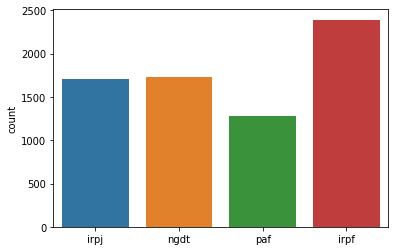

In [ ]:
sns.countplot(y_treinamento_rotulos);

In [ ]:
y_treinamento_rotulos[y_treinamento_rotulos == 'irpj'] = 0
y_treinamento_rotulos[y_treinamento_rotulos == 'irpf'] = 1
y_treinamento_rotulos[y_treinamento_rotulos == 'ngdt'] = 2
y_treinamento_rotulos[y_treinamento_rotulos == 'paf'] = 3
y_treinamento_rotulos = y_treinamento_rotulos.astype(np.int32)
y_treinamento_rotulos

array([0, 2, 3, ..., 2, 0, 0], dtype=int32)

##4.  Conversão do voto em vetor númerico 

In [ ]:
num_words = 2**16
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
# Tokenizar os dados de treinamento 
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_treinamento_preprocessado)

# Obter total de palavras de dados de treinamento
vocab_size = len(tokenizer.word_index) + 1

# Transforma cada texto em uma sequência de inteiros.
X_treinamento_vetor_numerico = tokenizer.texts_to_sequences(X_treinamento_preprocessado)

# Obter o comprimento máximo da sequência de treinamento para uso no padding (preenchimento)
max_len = max([len(x) for x in X_treinamento_vetor_numerico])

# Transformar a lista de sequências de tamanho variável em uma matriz 2D numpy de forma (número de linhas, comprimento da maior sequência).
X_treinamento_vetor_numerico = pad_sequences(X_treinamento_vetor_numerico, padding=pad_type, truncating=trunc_type, maxlen=max_len)

##5. Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):
  '''
Construção do modelo: 
Para isso, utilizei uma classe DCNN herdando de tf.keras.model (classe base do keras do tensorflow para a construção de modelos de redes neurais). 
O modelo agrupa camadas em um objeto com recursos de treinamento e inferência.
São duas duas maneiras de instanciar o modelo : 1 - Com a API Funcional ou 2 - Subclassificando a classe Model. 
Optei pela subclassificação da classe, conforme descrito no curso Processamento de Linguagem Natural com Deep Learning, IA Expert Academy, 
tópico Redes neurais convolucionais para PLN – implementação.
Os parâmetros do construtor da classe utilizados foram Self (indica que ao criarmos uma instância desta classe, 
ela vai se referir a um objeto e não à própria classe), vocab_size (tamanho do vocabulário - varia conforme tratamento das palavras por lema, 
stemer ou palavras originais), emb_dim (200 - tamanho da matriz de embedings escolhido após alguns testes. 
Não fiz tunning, pois a classificação não é o foco do TCC), nb_filters (100 – número de filtros para cada dimensão), 
ffn_units (256 - número de neurônios da rede neural densa) e nb_classes (4 - número de classes ou categorias), dropout_rate=0.2 
(técnica utilizada para evitar overfiting . Serão zerados 20% dos neurônios).            
O método construtor da classe é chamado para criar um novo modelo.
A camada de embedding gera uma matriz linha igual ao tamanho do vocabulário linhas e 200 colunas conforme definido em emb_dim.
O objetivo é encontrar redução de dimensionalidade na representação dos vetores e ao mesmo tempo adicionar relação semântica entre as palavras.
  Definição das camadas de convolução:
São 3 camadas de convolução com 100 filtros de 2 linhas na primeira camada, 3 linhas na segunda e 4 linhas na terceira. 
O preenchimento padding= same retorna o mesmo tipo de dados no mesmo formato. Como função de ativação utilizei a padrão, relu.
Pooling (Agregação) e concatenação:
Em seguida, está a definição da camada de pooling para reduzir escala (downsampling) que irá gerar o vetor final 
para entrada na rede neural densa. Utilizada a função GlobalMaxPool1D que reduz a resolução da representação de entrada, 
assumindo o valor máximo após o produto escalar entre os vetores que representam as palavras e os vetores que representam os filtros. 
Estrutura da rede neural densa
A primeira camada oculta tem 256 neurônios e não precisamos definir a quantidade de neurônios da camada de entrada, 
pois depois iremos juntar o final do pooling com a entrada e o próprio Tensorflow fará automaticamente.
A função de ativação SoftMax é usada (normaliza entre 0 e 1 as saídas, em um problema multi-classes, obtidas por um classificador linear – ex. neurônios – 
e é aplicada na camada de saída da rede - output layer), pois temos 4 categorias e a função irá retornar uma probabilidade para cada uma das classes.
Foi definida função para ligar a matriz de embedding com os filtros da camada bigram (duas palavras) e desta para a camada de pooling, 
com os filtros da camada trigram (três palavras) e desta para a camada de pooling, e com filtros da camada fourgram (quatro palavras) e 
desta para a camada de pooling. O processamento é em paralelo. Ao final, as saídas são concatenadas e tornam-se a entrada para a rede neural em seqüência, 
camada densa, camada de dropout e, finalmente, a saída (output layer).
Treinamento:
Os únicos parâmetros passados foram o número de épocas (5) e a quantidade de registros no treinamento para a atualização dos pesos (minibatch = 64).
  '''

  def __init__(self,
               vocab_size,
               emb_dim=200,
               nb_filters=100,
               ffn_units=256,
               nb_classes=4,
               dropout_rate=0.2,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')
    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

##6.   Configuração dos parâmetros

In [ ]:
emb_dim = 200 #melhor fazer o tunning, mas não é o meu foco
nb_filters = 100 #para cada um dos filtros, teremos 100 versões únicas 
ffn_units = 256 #números de neurônios na camada escondida da rede neural densa
batch_size = 64
nb_classes = 4  #número das classes. 4
dropout_rate = 0.2 #para a maioria dos casos, 0.2 tem resultados interessantes.
nb_epochs = 5

##7. Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)
Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = Dcnn.fit(X_treinamento_vetor_numerico, y_treinamento_rotulos,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)

Epoch 1/5
101/101 [==============================] - 1335s 13s/step - loss: 1.0086 - accuracy: 0.5870 - val_loss: 0.4031 - val_accuracy: 0.8668
Epoch 2/5
101/101 [==============================] - 1338s 13s/step - loss: 0.2919 - accuracy: 0.9082 - val_loss: 0.3237 - val_accuracy: 0.8822
Epoch 3/5
101/101 [==============================] - 1331s 13s/step - loss: 0.0883 - accuracy: 0.9804 - val_loss: 0.3398 - val_accuracy: 0.8738
Epoch 4/5
101/101 [==============================] - 1333s 13s/step - loss: 0.0361 - accuracy: 0.9926 - val_loss: 0.3331 - val_accuracy: 0.8864
Epoch 5/5
101/101 [==============================] - 1336s 13s/step - loss: 0.0146 - accuracy: 0.9977 - val_loss: 0.3583 - val_accuracy: 0.8864


##8. Salvar no drive o modelo treinado

In [ ]:
#Salvar no drive o modelo treinado
if tipo_modelo == 'lema':
  Dcnn.save('/content/drive/MyDrive/modelo_Dcnn_lema')
elif tipo_modelo == 'stemer':
  Dcnn.save('/content/drive/MyDrive/modelo_Dcnn_stemer')
else:
  Dcnn.save('/content/drive/MyDrive/modelo_Dcnn_original')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/modelo_Dcnn_original/assets


# Etapa 3: Avaliação do modelo

1. Função preprocessamento.
* A descrição desta função encontra-se no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*. É a mesma função. Pensei em deixá-la em uma biblioteca minha no drive para importá-la, mas tive problemas com referências e optei por simplesmente replicá-la em todos os notebooks nos quais irei utilizá-la.

2.   Ler arquivos do Drive gravados pelo notebook *TCC_p01_preparar_X_treinamento_e_y_teste*
*   Ler do drive os dataframes X_teste e y_teste.

3. Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.

4. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]

5. Conversão do voto em vetor númerico
* Com base no Tokenize com os dados de treinamento serão feitas as transformações, agora, nos dados de teste.
* Transforma cada texto em uma sequência de inteiros.
* O comprimento máximo, max_len, para uso no padding é o mesmo do treinamento. No caso, max_len lema = 7622, max_len stemer = 7610 e max_len palavras originais = 7622.
Esses valores precisam ser atribuídos ao max_len manualmente.
* Transformar a lista de sequências de tamanho variável em uma matriz 2D numpy de forma (número de linhas, comprimento da maior sequência). Argumentos: pad_type e trunc_type.

6. Carregar modelo treinado

7. Avaliação com lematização

* Fazer a previsão com o modelo treinado e a base de teste
* Mostrar o mapa de calor da matriz de confusão
* Apurar a acurácia

8. Avaliação com stemização

* Fazer a previsão com o modelo treinado e a base de teste
* Mostrar o mapa de calor da matriz de confusão
* Apurar a acurácia

9. Avaliação com palavras originais

* Fazer a previsão com o modelo treinado e a base de teste
* Mostrar o mapa de calor da matriz de confusão
* Apurar a acurácia

##1. Função preprocessamento.

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

##2. Ler arquivos do Drive gravados pelo notebook *TCC_p01_preparar_X_treinamento_e_y_teste*

In [ ]:
#Carregar dataframe teste (X e y) diretamente do drive.
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True)

##3. Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.

In [ ]:
#rodar preprocessamento selecionando entre lema, stemer ou original.
if tipo_modelo == 'lema':
  X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('lema',))
elif tipo_modelo == 'stemer':
  X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('stemer',))
else:
  X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('original',))

In [ ]:
#transform X_teste e y_teste em numpy.ndarray
X_teste_preprocessado = X_teste.iloc[:, 0].values
y_teste_rotulos = y_teste.iloc[:, 0].values

##4. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]

In [ ]:
#rotulos para o gráfico matriz de confusão
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']

##5. Conversão do voto (teste) em vetor númerico

In [ ]:
#max_len lema = 7622, max_len stemer = 7610 e max_len original = 7622
max_len

7622

In [ ]:
# Transforma cada texto em uma sequência de inteiros.
X_teste_vetor_numerico = tokenizer.texts_to_sequences(X_teste_preprocessado)

# Transformar a lista de sequências de tamanho variável em uma matriz 2D numpy de forma (número de linhas, comprimento da maior sequência).
X_teste_vetor_numerico = pad_sequences(X_teste_vetor_numerico, padding=pad_type, truncating=trunc_type, maxlen=max_len)

##6. Carregar modelo treinado


In [ ]:
#Carregando modelo treinado que foi salvo no drive.
if tipo_modelo == 'lema':
  Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_lema')
elif tipo_modelo == 'stemer':
  Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_stemer')
else:
  Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_original')

In [ ]:
#Verificando a arquitetura do modelo
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  9765600   
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  77056     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0      

##7. Avaliação com lematização

In [ ]:
#Fazendo a previsão do teste
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

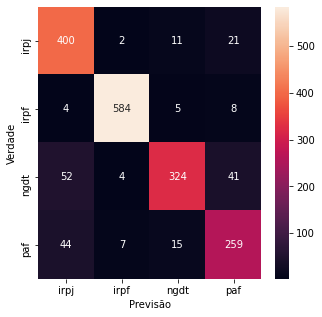

In [ ]:
#Mostrar o mapa de calor da matriz de confusão
conf_mat_nb = confusion_matrix(y_teste_rotulos, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
#Acurácia
accuracy_score(y_teste_rotulos, lista_predict)

0.879842784952274

#8. Avaliação com stemização

In [ ]:
#Fazendo a previsão do teste
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

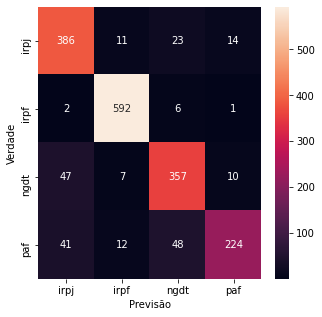

In [ ]:
#Mostrar o mapa de calor da matriz de confusão
conf_mat_nb = confusion_matrix(y_teste_rotulos, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
#Acurácia
accuracy_score(y_teste_rotulos, lista_predict)

0.8753509264458169

##9. Avaliação com palavras originais

In [ ]:
#Fazendo a previsão do teste
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

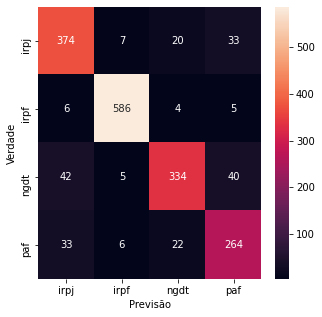

In [ ]:
#Mostrar o mapa de calor da matriz de confusão
conf_mat_nb = confusion_matrix(y_teste_rotulos, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
#Acurácia
accuracy_score(y_teste_rotulos, lista_predict)

0.8747894441325098